# Plot repeating events

Plot the repeating gouge events generated by the gouge patch.

2024.06.05 Kurama Okubo

- 2024.11.1 update for the merged catalog. We modified the threshold criteria so that we do not use the maximum value of the correlation coefficient to the stacked waveform. We threshold out the HMPW with the predefined criteria. On the other hand, we use the max cc to plot the Figure 1 repeating events for the sake of visuallization.

- 2024.12.6 update the plotting magnitude estimated from fitting the STF.
- 2024.12.8 update plot the events where four sensors are fitted for the master plot.
- 2024.12.19 update apply one-way band-pass filter between 0.1-1Hz instead of high-pass filter. Re-adjusted the onset picks. It used to be low-passed with the prefilter of instrumental response removal.
- 2024.1.22 update `P_win_ind` to align the P wave window
- 2025.2.7 update to plot P and S arrivals
- 2025.3.31 update to remove y ticks black lines.
- 2025.4.10 update the figure labels for supplementary figures.

In [151]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
import pickle 
import seaborn as sns
import copy
from scipy.optimize import minimize
from scipy import integrate 

from obspy.signal.cross_correlation import correlate, xcorr_max

from obspy.core.utcdatetime import UTCDateTime    

from compute_reflections import *

%load_ext autoreload
%autoreload 2

plt.rcParams['lines.linewidth'] = 1.0

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = False

plt.rcParams["savefig.transparent"] = False #True

plt.rcParams['axes.linewidth'] = 0.75
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
# channel table
channel_finame = '../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'

# input datadir
# data_inputdir = "../../SourceInversion/data/07_DATA_MTinversion"
data_inputdir = "../../SourceInvFit/data/07_DATA_MTinversion" # for the tiny events 

# select balldrop calibration model
balldrop_model=4 # 2 for the model only with SiTj, 4 for the SiTjbeta

if balldrop_model==4:
    aperturecorrection=True
elif balldrop_model==2:
    aperturecorrection=False
else:
    aperturecorrection=False
    
# Path for event data
datadir = f"../../SourceInvFit/data/06_assemble_gf_model{balldrop_model}"

dataoutdir = "../data/01_plot_gougeevents"
if not os.path.exists(dataoutdir):
    os.makedirs(dataoutdir)

In [153]:
figdir = "../figure/01_plot_gougeevents"
if not os.path.exists(figdir):
    os.makedirs(figdir)



In [154]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())
# channel_loc

# Read the waveforms
We read the waveforms compiled in `06_assemble_greensfunction_MTinv_removeresp`.
We use the `stage 1`, where the instrumental response and gain correction by the ball drop were applied.


In [155]:
repeated_sensor = "OL23" # 07, 08, 22, 23, ### we remove 24 due to low S/N 
gougepatch_id = "G3" # to set output filename

# load best parameters
# Path to the best fit source parameters
bestfitsourceparam_finame = f"../../SourceInvFit/data/datacsv/gridsearch_bestparam_M0andTR_fb03-087.csv"

df_bestparam = pd.read_csv(bestfitsourceparam_finame, index_col=0) # from waveform inversion
datacases = df_bestparam.index
df_bestparam.head()

,VR_P_best,M0_best,TR_best,rake_best
fb03-087__0004,0.89,0.57,3.3,0
fb03-087__0009,0.73,0.05,3.1,0
fb03-087__0018,0.87,0.61,3.5,0
fb03-087__0019,0.79,0.05,3.1,0
fb03-087__0020,0.89,0.77,3.3,0


# Update source parameters with the STF fitting
If we find the datasheet of source parameters obtained by the STF fitting, we use the updated values.

In [156]:
# NOTE: bestfit M0 should be updated after the evaluation of fitting STF.
# Update: read the stats obtained by the STF fitting
expr_id = 87
gougepatch_id = "G3" # to set output filename
denoise_method = "detrend"
Qinv_quart = 50
k_waterlevel = 0.3

# IfSTFstatsExist = os.path.exists(f"../../HalfMaximumPulseWidth/data/df_STF_stats_stacked_all__{gougepatch_id}.csv")
foname_mean = f"../data/05_STFstats/SourceParam_meanstd_fb03-{expr_id:03d}_{gougepatch_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.csv"

IfSTFstatsExist = os.path.exists(foname_mean)
if IfSTFstatsExist:
    print(f"Datasheet {os.path.basename(foname_mean)} found.")

expr_id = 87

if IfSTFstatsExist:
    df_stats = pd.read_csv(foname_mean, index_col=0)
    df_stats_case = df_stats[df_stats["Qinv_quart"] == f"{Qinv_quart}"]
    df_stats_case_sorted = df_stats_case.sort_values(by="M0_mean", ascending=False)

else:
    df_stats_case_sorted = pd.DataFrame(columns = ["datacase", "gougeevent_id"])

Datasheet SourceParam_meanstd_fb03-087_G3_wlv_0.30_denoisemethod_detrend.csv found.


In [157]:
df_stats_case_sorted.head()

,datacase,gougeevent_id,Qinv_quart,Nvalidsensors,M0_mean,M0_std,Tw_mean,Tw_std
index,,,,,,,,
fb03-087,fb03-087__0088,88,50,4,1.258743,0.645682,0.000002,2.308593e-07
fb03-087,fb03-087__0129,129,50,4,1.134119,0.407475,0.000003,1.733592e-07
fb03-087,fb03-087__0031,31,50,4,0.974691,0.262768,0.000003,2.155345e-07
fb03-087,fb03-087__0095,95,50,4,0.912162,0.267969,0.000003,1.184915e-07
fb03-087,fb03-087__0020,20,50,4,0.867075,0.209970,0.000003,1.379112e-07


## Update the source parameter table

In [158]:
df_sourceparam = pd.DataFrame(columns = ["datacase", "gougeevent_id", "Nvalidsensors", "M0", "Tw", "M0_fromwavfit", "Tw_fromwavfit" ])

for datacase in datacases:
    gougeevent_id = int(datacase.split("__")[1])
    df_event_fromSTFfit = df_stats_case_sorted[df_stats_case_sorted["datacase"]==datacase]
    if len(df_event_fromSTFfit)<1:
        # No STF fit avalilable.
        data = {"datacase": [datacase], "gougeevent_id": gougeevent_id, "Nvalidsensors": 0,
               "M0": df_bestparam.loc[datacase, "M0_best"], "Tw": df_bestparam.loc[datacase, "TR_best"],
               "M0_fromwavfit": df_bestparam.loc[datacase, "M0_best"], "Tw_fromwavfit": df_bestparam.loc[datacase, "TR_best"],}

    else:
        # use the STF fit
        data = {"datacase": [datacase], "gougeevent_id": gougeevent_id, "Nvalidsensors": df_event_fromSTFfit["Nvalidsensors"].values[0],
               "M0": df_event_fromSTFfit["M0_mean"].values[0], "Tw": df_event_fromSTFfit["Tw_mean"].values[0]*1e6,
                "M0_fromwavfit": df_bestparam.loc[datacase, "M0_best"], "Tw_fromwavfit": df_bestparam.loc[datacase, "TR_best"],}      
    
    if not df_sourceparam.empty:
        df_sourceparam = pd.concat([df_sourceparam, pd.DataFrame.from_dict(data)])
    else:
        df_sourceparam = pd.DataFrame.from_dict(data)

df_sourceparam = df_sourceparam.set_index("datacase")

NOTE: Tw_fromwavfit is without the Q deconv, and the detrend algorithm is different from STF fitting.

In [159]:
# df_sourceparam

<Axes: xlabel='M0', ylabel='M0_fromwavfit'>

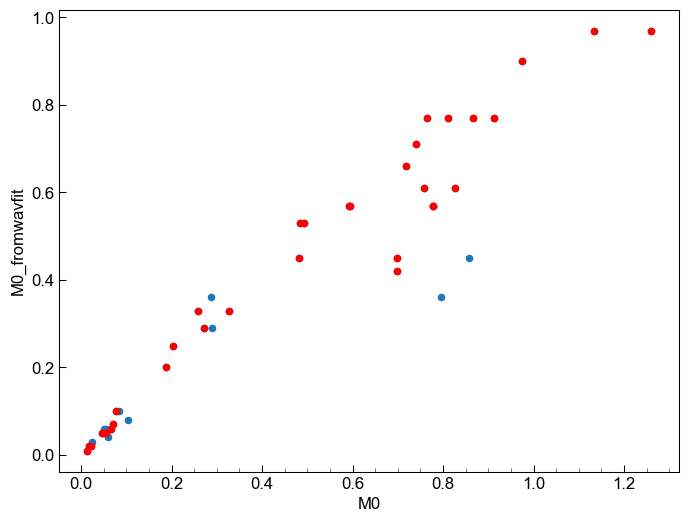

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
df_sourceparam.plot.scatter(x="M0", y="M0_fromwavfit", ax=ax)
df_sourceparam[df_sourceparam["Nvalidsensors"] >= 4].plot.scatter(x="M0", y="M0_fromwavfit", c="r", ax=ax)

In [161]:
df_sourceparam.head()

,gougeevent_id,Nvalidsensors,M0,Tw,M0_fromwavfit,Tw_fromwavfit
datacase,,,,,,
fb03-087__0004,4,4,0.594031,2.557904,0.57,3.3
fb03-087__0009,9,4,0.047135,2.346557,0.05,3.1
fb03-087__0018,18,4,0.757592,2.864507,0.61,3.5
fb03-087__0019,19,4,0.056071,2.484603,0.05,3.1
fb03-087__0020,20,4,0.867075,2.766544,0.77,3.3


In [162]:
df_sourceparam
df_sourceparam_sorted = df_sourceparam.sort_values(by="M0", ascending=False)
# df_sourceparam_sorted

In [163]:
datacases_sorted = df_sourceparam_sorted.index.values

In [164]:
datacases_sorted

array(['fb03-087__0088', 'fb03-087__0129', 'fb03-087__0031',
       'fb03-087__0095', 'fb03-087__0020', 'fb03-087__0111',
       'fb03-087__0099', 'fb03-087__0072', 'fb03-087__0076',
       'fb03-087__0120', 'fb03-087__0077', 'fb03-087__0027',
       'fb03-087__0018', 'fb03-087__0061', 'fb03-087__0131',
       'fb03-087__0100', 'fb03-087__0109', 'fb03-087__0004',
       'fb03-087__0062', 'fb03-087__0089', 'fb03-087__0085',
       'fb03-087__0052', 'fb03-087__0050', 'fb03-087__0075',
       'fb03-087__0055', 'fb03-087__0038', 'fb03-087__0069',
       'fb03-087__0040', 'fb03-087__0043', 'fb03-087__0059',
       'fb03-087__0102', 'fb03-087__0118', 'fb03-087__0044',
       'fb03-087__0024', 'fb03-087__0049', 'fb03-087__0019',
       'fb03-087__0110', 'fb03-087__0030', 'fb03-087__0081',
       'fb03-087__0009', 'fb03-087__0037', 'fb03-087__0021',
       'fb03-087__0126', 'fb03-087__0128'], dtype=object)

## Append the column of event timing

In [165]:
aftershock_ids = [3,4,7,15,16,17,32,33,43,46,51,52,56,57,62,63,67,68,69,76,77,80,87,89,
                  90,92,93,100,102,103,104,105,106,107,108,109,111,114,116,118,120,123,124,128,132]; # we visually categorized the aftershocks.

df_sourceparam_sorted["eventtiming"] = 0 # foreshock

for index, row in df_sourceparam_sorted.iterrows():
    gougeevent_id = int(index.split("__")[-1])
    if gougeevent_id in aftershock_ids:
        df_sourceparam_sorted.loc[index, "eventtiming"] = 1
    

In [166]:
st_repeat_raw = Stream()
st_repeat = Stream()

for datacase in datacases_sorted:
# datacase = datacases[4] # We repeated running the notebook with selecting the datacase to complete the grid search for all the events.
    # print(f"start processing {repeated_sensor} event {datacase}.")

    # load event trace
    st_event = read(datadir + "/{}_AEwaveform.pickle".format(datacase)) # this contains observation and green's function within a thresholded distance
    tr_obs_raw = st_event.select(station=repeated_sensor, location="raw")[0]
    tr_obs_afterremovalresp = st_event.select(station=repeated_sensor, location="stage1")[0]
    st_repeat_raw.append(tr_obs_raw)
    st_repeat.append(tr_obs_afterremovalresp)
    


In [167]:
st_repeat

44 Trace(s) in Stream:

FB.OL23.stage1.OZ | 2023-05-29T00:02:41.09713600Z - 2023-05-29T00:02:41.09744600Z | 10000000.0 Hz, 3101 samples
...
(42 other traces)
...
FB.OL23.stage1.OZ | 2023-05-29T00:04:01.51284000Z - 2023-05-29T00:04:01.51315000Z | 10000000.0 Hz, 3101 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [168]:
st_repeat[0]

FB.OL23.stage1.OZ | 2023-05-29T00:02:41.09713600Z - 2023-05-29T00:02:41.09744600Z | 10000000.0 Hz, 3101 samples

In [169]:
# compute source distance
dist_all = []
for tr in st_repeat:
    dist_all.append(tr.stats.dist)

dist = np.mean(dist_all)
dist

96.20966018621243

In [170]:
with open(data_inputdir+"/GridSearch_param_{}_balldropmodel{}.pickle".format(datacases[0], balldrop_model),"rb") as fo:
    param = pickle.load(fo)


## Plot raw waveform

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


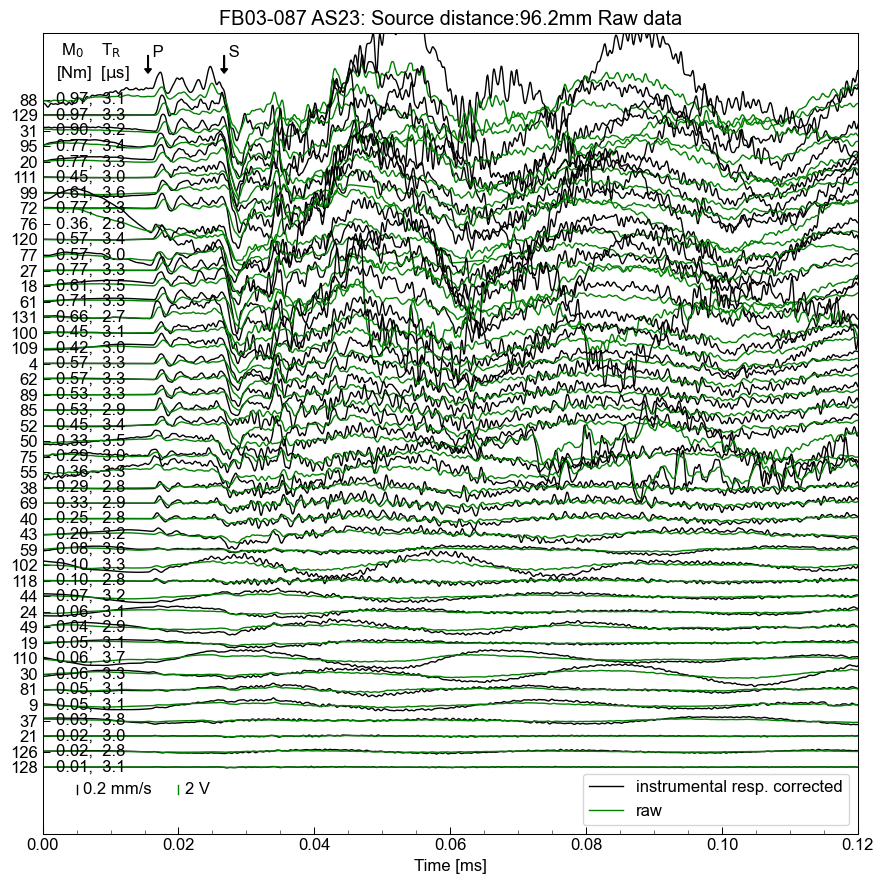

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))


selected_sensor = st_repeat[0].stats.station
tvec = st_repeat[0].times()*1e3


# compute P and S arrival
tp = dist/param['cp']
ts = dist/param['cs']

yshift = 0
del_yshift = 7e-3 #4e-3
ampnorm = 0.05 # for tiny events #0.1 #12
yspan = 0# 1.2e-3
expr_id = datacases[0].split('__')[0]

pretrigger = st_repeat[0].stats.pretrigger # [ms]
ytickloc = []
yticklabel = []

# Plot repeated events
raw_ampnorm = 5e2

for i, datacase in enumerate(datacases_sorted):
    # i = 4
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.dataindex[6:] for x in st_repeat].index(datacase)
    tr_obs = st_repeat[tr_ind]
    tr_obs_raw = st_repeat_raw[tr_ind]
    assert(tr_obs.stats.dataindex[6:]==datacase) # check if the correct datacase is selected
    assert(tr_obs_raw.stats.dataindex[6:]==datacase) # check if the correct datacase is selected
    ytickloc.append(-yshift)
    yticklabel.append(f"{gougeevent_id:g}")
    h1 = ax.plot(tvec-pretrigger, (tr_obs.data/ampnorm) - yshift, "k-", label="instrumental resp. corrected")
    h2 = ax.plot(tvec-pretrigger, (tr_obs_raw.data/raw_ampnorm) - yshift, "g-", label="Raw")
    # ax.plot(tvec-pretrigger+dt_shift_p, (tr_syn.data/ampnorm) - yshift - yspan, "r-", lw=1)
    yshift = yshift + del_yshift

# Annotate estimated source parameters
annot_x = 0.0027
annot_x_text = 0.002
annot_y = -0.0019

for i, datacase in enumerate(datacases_sorted):
    # print(datacase)
    # for the raw plot, use wavfit
    M0_best = df_sourceparam_sorted.loc[datacase, "M0_fromwavfit"]
    TR_best = df_sourceparam_sorted.loc[datacase, "Tw_fromwavfit"]

    ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f},  {:.1f}".format(M0_best, TR_best), ha="left")
    
annot_txt = [r"M$_{\mathrm{0}}$", r"T$_{\mathrm{R}}$"]
annot_txt_unit = ["[Nm]", r"[$\mathrm{\mu}$s]"]
ax.text(annot_x, ytickloc[0]+0.02, "{}    {}".format(*annot_txt), ha="left")
ax.text(annot_x-0.0008, ytickloc[0]+0.01, "{}  {}".format(*annot_txt_unit), ha="left")

# annotate the scale of velocity
scale_x = 0.005
scale_y = -(ytickloc[-1]-0.01)
scale_amplitude = 0.2e-3 #[mm/s]
ax.plot([scale_x, scale_x], np.array([-scale_amplitude/2, +scale_amplitude/2])/ampnorm-scale_y, "k-");
ax.text(scale_x+0.001, -(scale_amplitude/2/ampnorm)-scale_y, f"{scale_amplitude*1e3:.1f} mm/s" )

# annotate the scale of voltage
scale_x2 = 0.02
scale_y2 = -(ytickloc[-1]-0.01)
scale_amplitude2 = 2.0 #[V]
ax.plot([scale_x2, scale_x2], np.array([-scale_amplitude2/2, +scale_amplitude2/2])/raw_ampnorm-scale_y2, "g-");
ax.text(scale_x2+0.001, -(scale_amplitude2/2/raw_ampnorm)-scale_y2, f"{scale_amplitude2:.0f} V" )

# annotate p and s arrival
arrow_y = 0.02
ax.arrow(tp, arrow_y, 0, -8e-3, width=1e-4, length_includes_head=True, head_length=2e-3,head_width=1e-3, color='k')
ax.arrow(ts, arrow_y, 0, -8e-3, width=1e-4, length_includes_head=True, head_length=2e-3,head_width=1e-3, color='k')
ax.text(tp, arrow_y-0.6e-3, " P", ha="left")
ax.text(ts, arrow_y-0.6e-3, " S", ha="left")

# # plot stacked trace
# yshift = yshift + 0.5*del_yshift
# ax.plot(tvec-pretrigger, (tr_stack.data/ampnorm) - yshift, "k-", lw=2)
# ytickloc.append(-yshift)
# yticklabel.append("Stacked")

# decoration of figure
ax.set_xlim([0.0, 0.12])
ax.set_ylim([ytickloc[-1]-0.03, ytickloc[0]+0.03])

ax.set_xlabel("Time [ms]")

ax.set_yticks(np.round(ytickloc, 3))
ax.set_yticklabels(yticklabel)

title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Raw data"

ax.legend(["instrumental resp. corrected", "raw"], loc=4)
ax.set_title(title_str)

fig.tight_layout()

plt.savefig(figdir + "/waveform_repeated_event_{}_{}_raw_afterinstrumentalcorrection_all.png".format(gougepatch_id, repeated_sensor), dpi=300)
plt.savefig(figdir + "/waveform_repeated_event_{}_{}_raw_afterinstrumentalcorrection_all.eps".format(gougepatch_id, repeated_sensor))


# Repick the onset of P wave pulse

To improve the pick time of the P wave pulse for triming the P wave window, we repick the onset of P wave arrival. 
We use the waveforms after the removal of instrumental response.

## Apply band-pass filter
To remove the low-frequency noise and stabilize the picking, we first apply the band-pass filter. We apply `freqmin = 100 kHz`.

In [172]:
# Parameters for filtering
# We use the same filter as the previously analyzed gouge events
freqmin = 0.1e6 #0.06e6 # apply highpass
freqmax = 1e6 # prefilter is applied when removing the instrumental response. pre_filt = (1e4, 2e4, 1e6, 2e6).

butterworth_order = 3

In [173]:
# freqmin = 60e3 # high-pass 60kHz
# butterworth_order = 3

# sos = signal.butter(butterworth_order, freqmin, 'highpass', fs=st_repeat[0].stats.sampling_rate, output='sos')
# b, a = signal.butter(butterworth_order, freqmin, 'highpass', fs=st_repeat[0].stats.sampling_rate, output='ba')
b, a = signal.butter(butterworth_order, (freqmin, freqmax), 'bandpass', fs=st_repeat[0].stats.sampling_rate, output='ba')

st_filt_repick = Stream()

for i, datacase in enumerate(datacases_sorted):
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.dataindex[6:] for x in st_repeat].index(datacase)
    tr_obs = st_repeat[tr_ind]
    assert(tr_obs.stats.dataindex[6:]==datacase)

    # using sos to minimize the numerical error of filter
    tr_obs_filtered = tr_obs.copy().taper(0.05)

    # Here we use the one-way filter as it is better to pick the onset of P as well as avoiding the acausal trend
    # tr_obs_filtered.data = signal.sosfilt(sos, tr_obs_filtered.data)
    tr_obs_filtered.data = signal.filtfilt(b, a, tr_obs_filtered.data, method='gust') # using two-way filter Gustafsson’s method

    # tr_obs_filtered.data = signal.sosfiltfilt(sos, tr_obs_filtered.data)
    st_filt_repick.append(tr_obs_filtered)

## Find the onset of P wave pulse

We developed the robust process flow to accurately pick the onset of P wave pulse as follows:

1. Trim the P wave window
2. Detrend the p wave window using the polynomial fitting. We select the order depending on the noise level. The long-period noise is removed by the detrend.
3. Find the peak location of P wave pulse using `signal.find_peaks()`.
4. To pick the onset of the wide range of the P wave pulse, we use the inflection of the pulse. Compute the second derivative of the waveform.
5. Find the maximum point of the second derivative of the waveform from the peak of P.

Note:The station far from the source sometimes shows low S/N for the P wave pulse, and finding the onset of P is difficult. In that case, we use the original tpick, which is at least consistent with the theoretical arrival of P wave.

In [174]:
datacases[36]

'fb03-087__0110'

In [175]:
# # Development: plot detailed picking algorithm

# for tr in st_filt_repick[36:37]: #[18:19]:
# # tr = st_filt_repick[7] # 16 # 19
    
#     fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    
#     tvec = tr.times()*1e3
#     gougeevent_id = int(tr.stats.dataindex.split("__")[-1])
#     fs = st_filt_repick[0].stats.sampling_rate
#     pwin_pre = 4e-6#3e-6
#     pwin_len = 4e-6
#     tpick_diff_thresh = 20 #15 # if the newly picked P onset is N points different from the original, use the original tpick.
#     pwin_init_noise_thresh = 1e-6
#     # mininflection_Nthresh = 5 # find max inflection larger than this points from peak
#     # maxinflection_Nthresh = 15 # find max inflection within this points from peak
    
#     # onset_amp_thresh = 0.1 # threshold fraction to find the onset
    
#     pp = tr.stats.pretrigger
#     pt = tr.stats.tpick
    
#     st_ind = np.where(tvec>(pp+pt-pwin_pre*1e3))[0][0]
#     et_ind = np.where(tvec>(pp+pt+pwin_len*1e3))[0][0]
#     pt_ind = np.where(tvec>(pp+pt))[0][0]
#     onset_p_origin = (pt_ind - st_ind) # relative location of the original tpick time

#     polarity = -1 * np.sign(tr.stats.xi1) * np.sign(channel_loc[repeated_sensor][1])
    
#     pwin_data = polarity*tr.data[st_ind:et_ind]
#     pwin_data_origin = copy.deepcopy(pwin_data) # copy the P win waveform to evaluate the peak value
#     Npwin_data = len(pwin_data)
    
#     # find the location of the peak in P 
#     # We detrend by polynomial fitting
#     # switch the order by the level of noise
#     pwin_init_noiselevel = np.std(pwin_data[:10])
#     # print(pwin_init_noiselevel)
#     if pwin_init_noiselevel>pwin_init_noise_thresh:
#         poly_order = 3
#     else:
#         poly_order = 1
        
#     tvec_data = np.array(range(Npwin_data)) * (1/fs)
#     k_poly = np.polynomial.polynomial.polyfit(tvec_data, pwin_data, poly_order)
#     tr_poly = np.polynomial.polynomial.polyval(tvec_data, k_poly)
#     pwin_data_detrended = pwin_data-tr_poly

#     # apply tapering
#     pwin_data_detrended *= signal.windows.hann(Npwin_data)
    
#     # pwin_data_detrended = signal.detrend(pwin_data)
#     peaks, _ = signal.find_peaks(pwin_data_detrended, prominence=1e-6) #threshold=5e-7 ) # prominence in [m/s]

#     # AS22 37 decrease the prominence
#     if (repeated_sensor in ["OL22"]) & (gougeevent_id==37):
#         peaks, _ = signal.find_peaks(pwin_data_detrended, prominence=1e-7) 
    
#     if peaks.size<1:
#         # no P peaks found due to low S/N. Use the original P pick
#         peak_P = 0
#         onset_p = onset_p_origin
    
#     else:
#         # if dist>100:
#         # Deprecated: find the peaks closest from the original tpick
#         #     peak_P = peaks[np.argmin(np.abs(peaks - onset_p_origin))]
#         # else:
        
#         # UPDATE: pick the largest value
#         peak_P = peaks[np.argmax(pwin_data_detrended[peaks])]

#         # Modify the peak location for AS07 event 110:
#         if (repeated_sensor in ["OL07"]) & (gougeevent_id==110):
#             peak_P = peaks[0]
        
#         # Modify the peak location for AS22 event 30:
#         elif (repeated_sensor in ["OL22"]) & (gougeevent_id in [30, 37, 110]):
#             peak_P = peaks[0]         
         
#         # compute inflection
#         pwin_data_d = np.gradient(pwin_data_detrended[peak_P::-1])
#         pwin_data_dd = np.gradient(np.gradient(pwin_data_detrended[peak_P::-1]))
#         peaks_onset, _ = signal.find_peaks(pwin_data_dd) #, width=3)

#         # if not peaks_onset.size:
#         #     print(i)
#         #     # further find the onset
#         #     peaks_onset, _ = signal.find_peaks(pwin_data_dd)
        
#         # threshold out the peaks by distance from the peak_P
#         # print(peaks_onset, peak_P)
#         # peaks_onset = peaks_onset[(mininflection_Nthresh<peaks_onset) & (peaks_onset<maxinflection_Nthresh)]
        
#         if peaks_onset.size<1:
#             # no found of new P pick. Use original tpick
#             peak_P = 0
#             onset_p = onset_p_origin
#         else:
#             # set the new P pick
#             # onset_p = peak_P - peaks_onset[np.argmin(np.abs(peaks_onset - onset_p_origin))]-1
#             # onset_p = peak_P - peaks_onset[0] - 1 # the onset is one step ahead of the inflection
#             onset_p  = peak_P-peaks_onset[np.argmax(pwin_data_dd[peaks_onset])] - 1
            
#         # Select the new or original tpick
#         # we confirmed that id AS07 110 is correct with new pick
#         if (repeated_sensor in ["OL07"]) & (gougeevent_id==110):
#             print(f"AS{repeated_sensor} event {gougeevent_id} uses a new pick.")

#         # AS08 128 is better with the original pick
#         elif (repeated_sensor in ["OL08"]) & (gougeevent_id==128):
#             onset_p = onset_p_origin

#         # AS22 30 is better with the new pick
#         elif (repeated_sensor in ["OL22"]) & (gougeevent_id==30):
#             print(f"AS{repeated_sensor} event {gougeevent_id} uses a new pick.")
#             onset_p  = peak_P-peaks_onset[0] - 1 # use second peak

#         # AS22 37 is better with the new pick
#         elif (repeated_sensor in ["OL22"]) & (gougeevent_id==37):
#             print(f"AS{repeated_sensor} event {gougeevent_id} uses a new pick.")
#             onset_p  = peak_P-peaks_onset[0] - 1 # use second peak

#         # AS22 55 is better with the new pick
#         elif (repeated_sensor in ["OL22"]) & (gougeevent_id==55):
#             print(f"AS{repeated_sensor} event {gougeevent_id} uses a new pick.")
#             onset_p  = peak_P-peaks_onset[1] - 1 # use second peak
#             # print(onset_p)
       
#         # AS22 110 is better with the new pick
#         elif (repeated_sensor in ["OL22"]) & (gougeevent_id==110):
#             print(f"AS{repeated_sensor} event {gougeevent_id} uses a new pick.")
#             onset_p  = peak_P-peaks_onset[0] - 1 # use second peak
#             # print(onset_p)
        
#         elif np.abs(onset_p - onset_p_origin) > tpick_diff_thresh:
#             # the new t pick is too far from the origin. Use the original tpick
#             onset_p = onset_p_origin
    
#     plotampnorm = np.abs(pwin_data_detrended[peak_P])
#     ax.plot(pwin_data_detrended/plotampnorm, "-", c="k")
#     ax.plot(tr_poly/plotampnorm, "--", c="k")
    
#     if peak_P>0:
#         ax.plot(peak_P, pwin_data_detrended[peak_P]/plotampnorm, "o", c="r")
    
#     ax.plot(peaks, np.zeros(len(peaks)), "o", c="y")
#     ax.plot(onset_p, 0, "+", c="b", label="new t pick")
#     ax.plot(onset_p_origin, 0, "v", c="g", label="original t pick")
#     gougeevent_id = int(tr.stats.dataindex.split("__")[-1])
#     titlestr = f"event ID: {gougeevent_id}"
#     ax.set_title(titlestr)
#     # plt.clf()
#     # plt.close()
    

In [176]:
# peaks_onset[(mininflection_Nthresh<peaks_onset) & (peaks_onset<maxinflection_Nthresh)]

In [177]:
# plt.plot(pwin_data_d, ".-")
# plt.plot(pwin_data_dd)
# plt.plot(pwin_data_detrended[peak_P::-1])
# plt.plot(peaks_onset, np.zeros(len(peaks_onset)), "o")

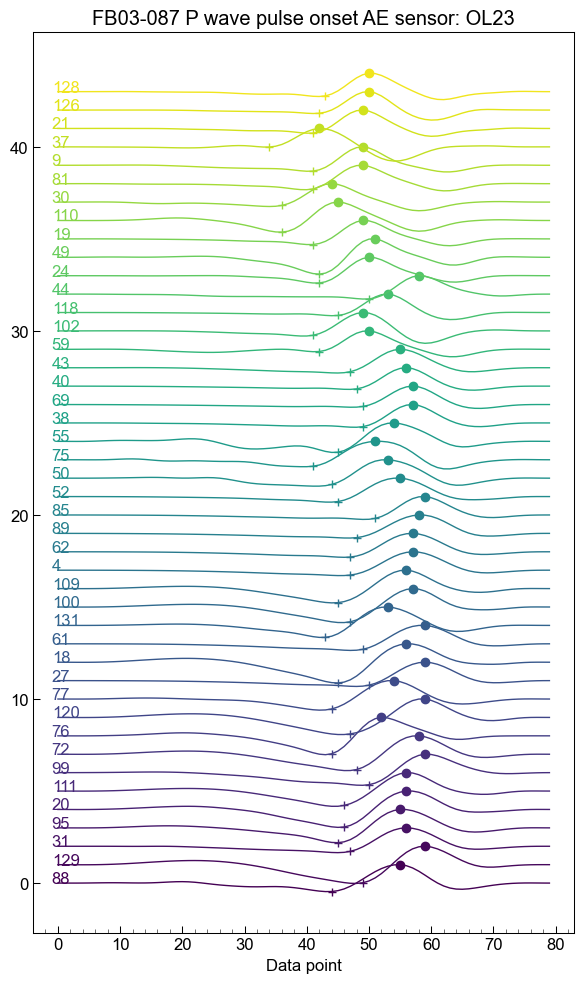

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(6, 10))

yshift = 0

lc = plt.get_cmap("viridis")
norm = plt.Normalize(0, len(st_filt_repick))

new_onset_p = dict()
peak_P_amp = dict() #save the peak P wave amplitude to normalize the waveform plot
peak_P_ind = dict() # save the timing of the P wave peak to align the P wave window

for i, tr in enumerate(st_filt_repick):
# tr = st_filt[14]
    
    gougeevent_id = int(tr.stats.dataindex.split("__")[-1])
    # print(gougeevent_id)
    datacase = tr.stats.dataindex[-14:]
    tvec = tr.times()*1e3
    
    fs = st_filt_repick[0].stats.sampling_rate
    pwin_pre = 4e-6 #3e-6
    pwin_len = 4e-6
    tpick_diff_thresh = 20 #15 # if the newly picked P onset is N points different from the original, use the original tpick.
    pwin_init_noise_thresh = 1e-6
    # mininflection_Nthresh = 5 # deprecated # find max inflection larger than this points from peak
    # maxinflection_Nthresh = 15 # deprecated #12 # find max inflection within this points from peak
    
    # onset_amp_thresh = 0.1 # threshold fraction to find the onset
    
    pp = tr.stats.pretrigger
    pt = tr.stats.tpick
    
    st_ind = np.where(tvec>(pp+pt-pwin_pre*1e3))[0][0]
    et_ind = np.where(tvec>(pp+pt+pwin_len*1e3))[0][0]
    pt_ind = np.where(tvec>(pp+pt))[0][0]
    onset_p_origin = (pt_ind - st_ind) # relative location of the original tpick time
    
    polarity = -1 * np.sign(tr.stats.xi1) * np.sign(channel_loc[repeated_sensor][1])
    
    pwin_data = polarity*tr.data[st_ind:et_ind]
    pwin_data_origin = copy.deepcopy(pwin_data) # copy the P win waveform to evaluate the peak value
    Npwin_data = len(pwin_data)
    
    # find the location of the peak in P 
    # We detrend by polynomial fitting
    # switch the order by the level of noise
    pwin_init_noiselevel = np.std(pwin_data[:10])
    # print(pwin_init_noiselevel)
    if pwin_init_noiselevel>pwin_init_noise_thresh:
        poly_order = 3
    else:
        poly_order = 1
    
    tvec_data = np.array(range(Npwin_data)) * (1/fs)
    k_poly = np.polynomial.polynomial.polyfit(tvec_data, pwin_data, poly_order)
    tr_poly = np.polynomial.polynomial.polyval(tvec_data, k_poly)
    pwin_data_detrended = pwin_data-tr_poly
    
    # apply tapering
    pwin_data_detrended *= signal.windows.hann(Npwin_data)
    
    # pwin_data_detrended = signal.detrend(pwin_data)
    peaks, _ = signal.find_peaks(pwin_data_detrended, prominence=1e-6) #threshold=5e-7 ) # prominence in [m/s]

    # AS22 37 decrease the prominence
    if (repeated_sensor in ["OL22"]) & (gougeevent_id==37):
        peaks, _ = signal.find_peaks(pwin_data_detrended, prominence=1e-7) 
    
    if peaks.size<1:
        # no P peaks found due to low S/N. Use the original P pick
        peak_P = 0
        onset_p = onset_p_origin
        P_amp = np.max(np.abs(pwin_data_origin)) # use the maximum value of the P window as the normalizing factor
    
    else:
        # if dist>100:
        # Deprecated: find the peaks closest from the original tpick
        #     peak_P = peaks[np.argmin(np.abs(peaks - onset_p_origin))]
        # else:
        
        # UPDATE: pick the largest value
        peak_P = peaks[np.argmax(pwin_data_detrended[peaks])]
                
        # Modify the peak location for AS07 event 110:
        if (repeated_sensor in ["OL07"]) & (gougeevent_id in [110]):
            peak_P = peaks[0]
       
        # Modify the peak location for AS22 event 30, 37:
        elif (repeated_sensor in ["OL22"]) & (gougeevent_id in [30, 37, 110]):
            peak_P = peaks[0]

        # Modify the peak location for AS22 event 49:
        elif (repeated_sensor in ["OL22"]) & (gougeevent_id in [49]):
            peak_P = peaks[1]

        # compute inflection
        pwin_data_d = np.gradient(pwin_data_detrended[peak_P::-1])
        pwin_data_dd = np.gradient(np.gradient(pwin_data_detrended[peak_P::-1]))
        peaks_onset, _ = signal.find_peaks(pwin_data_dd) #, width=3)
        
        # if not peaks_onset.size:
        #     print(i)
        #     # further find the onset
        #     peaks_onset, _ = signal.find_peaks(pwin_data_dd)

        # threshold out the peaks by distance from the peak_P
        # print(peaks_onset, peak_P)
        # peaks_onset = peaks_onset[peaks_onset<maxinflection_Nthresh]
        # peaks_onset = peaks_onset[(mininflection_Nthresh<peaks_onset) & (peaks_onset<maxinflection_Nthresh)]

        if peaks_onset.size<1:
            # no found of new P pick. Use original tpick
            peak_P = 0
            onset_p = onset_p_origin
        else:
            # set the new P pick
            # onset_p = peak_P - peaks_onset[np.argmin(np.abs(peaks_onset - onset_p_origin))]-1
            # onset_p = peak_P - peaks_onset[0] - 1 # the onset is one step ahead of the inflection
            onset_p  = peak_P-peaks_onset[np.argmax(pwin_data_dd[peaks_onset])] - 1

        # Using the value of the detrended P, especially for the tiny events.
        # P_amp = pwin_data_detrended[peak_P] - pwin_data_detrended[onset_p] # update: use the relative amplitude from the onset
        # Update: use the absolute P peak as P_amp or the relative amplitude depending on the sensors
        if repeated_sensor == "OL22":
            P_amp = pwin_data_detrended[peak_P]
        else:
            P_amp = pwin_data_detrended[peak_P] - pwin_data_detrended[onset_p]

        # P_amp = pwin_data_origin[peak_P]
        
    # Select the new or original tpick
    # we confirmed that id AS07 110 is correct with new pick
    if (repeated_sensor in ["OL07"]) & (gougeevent_id in [110]):
        print(f"AS{repeated_sensor} event {gougeevent_id} uses a new pick.")

    # AS08 128 is better with the original pick
    elif (repeated_sensor in ["OL08"]) & (gougeevent_id==128):
        print(f"AS{repeated_sensor} event {gougeevent_id} uses an original pick.")
        onset_p = onset_p_origin
        
    # AS22 30 is better with the new pick
    elif (repeated_sensor in ["OL22"]) & (gougeevent_id==30):
        print(f"AS{repeated_sensor} event {gougeevent_id} uses a new pick.")
        onset_p  = peak_P-peaks_onset[0] - 1 # use second peak

    # AS22 37 is better with the new pick
    elif (repeated_sensor in ["OL22"]) & (gougeevent_id==37):
        print(f"AS{repeated_sensor} event {gougeevent_id} uses a new pick.")
        onset_p  = peak_P-peaks_onset[0] - 1 # use second peak
        
    # AS22 55 is better with the new pick
    # elif (repeated_sensor in ["OL22"]) & (gougeevent_id==55):
    #         print(f"AS{repeated_sensor} event {gougeevent_id} uses a new pick.")
    #         onset_p  = peak_P-peaks_onset[1] - 1 # use second peak
        
    # AS22 110 is better with the new pick
    elif (repeated_sensor in ["OL22"]) & (gougeevent_id==110):
        print(f"AS{repeated_sensor} event {gougeevent_id} uses a new pick.")
        onset_p  = peak_P-peaks_onset[0] - 1 # use second peak
        # print(onset_p)     
    
    elif np.abs(onset_p - onset_p_origin) > tpick_diff_thresh:
        # the new t pick is too far from the origin. Use the original tpick
        onset_p = onset_p_origin


    new_onset_p[datacase] = st_ind + onset_p
    peak_P_amp[datacase] = P_amp
    peak_P_ind[datacase] = st_ind + peak_P # update: for the P win zoom window align
    
    ax.plot(pwin_data_detrended/pwin_data_detrended[peak_P]-yshift, "-", c=lc(norm(i)))
    ax.text(-1, pwin_data_detrended[0]/pwin_data_detrended[peak_P]-yshift, f"{gougeevent_id}", c=lc(norm(i)))
    # ax.plot(pwin_data_grad/np.max(pwin_data_grad)-yshift, "--", c=lc(norm(i)))
    ax.plot(peak_P, pwin_data_detrended[peak_P]/pwin_data_detrended[peak_P]-yshift, "o", c=lc(norm(i)))
    ax.plot(onset_p, pwin_data_detrended[onset_p]/pwin_data_detrended[peak_P]-yshift, "+", c=lc(norm(i)))

    yshift -= 1

ax.set_xlabel("Data point")
titlestr = f"FB03-087 P wave pulse onset AE sensor: {repeated_sensor}"
ax.set_title(titlestr)

fig.tight_layout()

plt.savefig(figdir + f"/onset_P_{gougepatch_id}_{repeated_sensor}.png", dpi=80)


In [179]:
# peak_P_ind

## Compile the data frame for the onset of P wave used for the trimming

In [180]:
df_onset = pd.DataFrame(new_onset_p, index=["onset_npt"]).T
tvec = st_filt_repick[0].times()*1e3 # [ms]
pretrigger = st_filt_repick[0].stats.pretrigger # [ms]
df_onset.loc[:, "sensor"] = repeated_sensor 
df_onset.loc[:, "onset_t[ms]"]=df_onset.apply(lambda x: tvec[x.onset_npt]-pretrigger, axis=1)
df_onset.loc[:, "onset_d_ref[mm]"]=df_onset.apply(lambda x: x["onset_t[ms]"]*param["cp"], axis=1)
df_onset.to_csv(dataoutdir+f"/P_repicked_onset_time_{gougepatch_id}_{repeated_sensor}.csv", float_format='%12.5g')
df_onset.head()

,onset_npt,sensor,onset_t[ms],onset_d_ref[mm]
fb03-087__0088,261,OL23,0.0161,99.82
fb03-087__0129,265,OL23,0.0165,102.30
fb03-087__0031,267,OL23,0.0167,103.54
fb03-087__0095,262,OL23,0.0162,100.44
fb03-087__0020,262,OL23,0.0162,100.44


# Plot all the events with the alignment at the onset of P

We plot all the events with the alignment at the onset of P. We use `st_filt_repick`, which the high-pass filter is applied.

In [181]:
# compute average pp_side
pp_side_all = []
pS_side_all = []
sP_side_all = []
for tr in st_repeat:
    (p_direct, pp_side, pp_bottom, pp_top, ppp_side) = compute_p_reflection(tr, param)

    # tps, tsp, (ideg_ps, jdeg_ps, ideg_sp, jdeg_sp) = compute_ps_and_sp_side_reflection(tr, param)
    tps, tsp, deg_Ps, deg_sP = compute_ps_and_sp_side_reflection2(tr, param)

    pp_side_all.append(pp_side)
    pS_side_all.append(tps)
    sP_side_all.append(tsp)

pp_side_mean = np.mean(pp_side_all)
sP_side_mean = np.mean(sP_side_all)
pS_side_mean = np.mean(pS_side_all)

(p_direct, pp_side, pp_bottom, pp_top, ppp_side), pp_side_mean, pS_side_mean, sP_side_mean,

((1.5665153920294367e-05,
  2.6469831697887017e-05,
  5.432229869764391e-05,
  7.65803092805907e-05,
  4.325861252088479e-05),
 2.7019506603103163e-05,
 3.990591260793686e-05,
 3.297227961669245e-05)

In [182]:
# Color for the all the events
skipcolor = 10
c_norm = mpl.colors.Normalize(vmin=0, vmax=len(datacases_sorted)+skipcolor)
lc_all = dict()
cmap = sns.color_palette("viridis_r", as_cmap=True)

for i, datacase in enumerate(datacases_sorted[::-1]):
    lc_all[datacase] = cmap(c_norm(i+skipcolor))


> Note: We measure the signal-to-noise ratio to avoid the large flactuation in the plotting with normalization.
> The SNR is measured by the peak P value to the noise window before the onset of P.

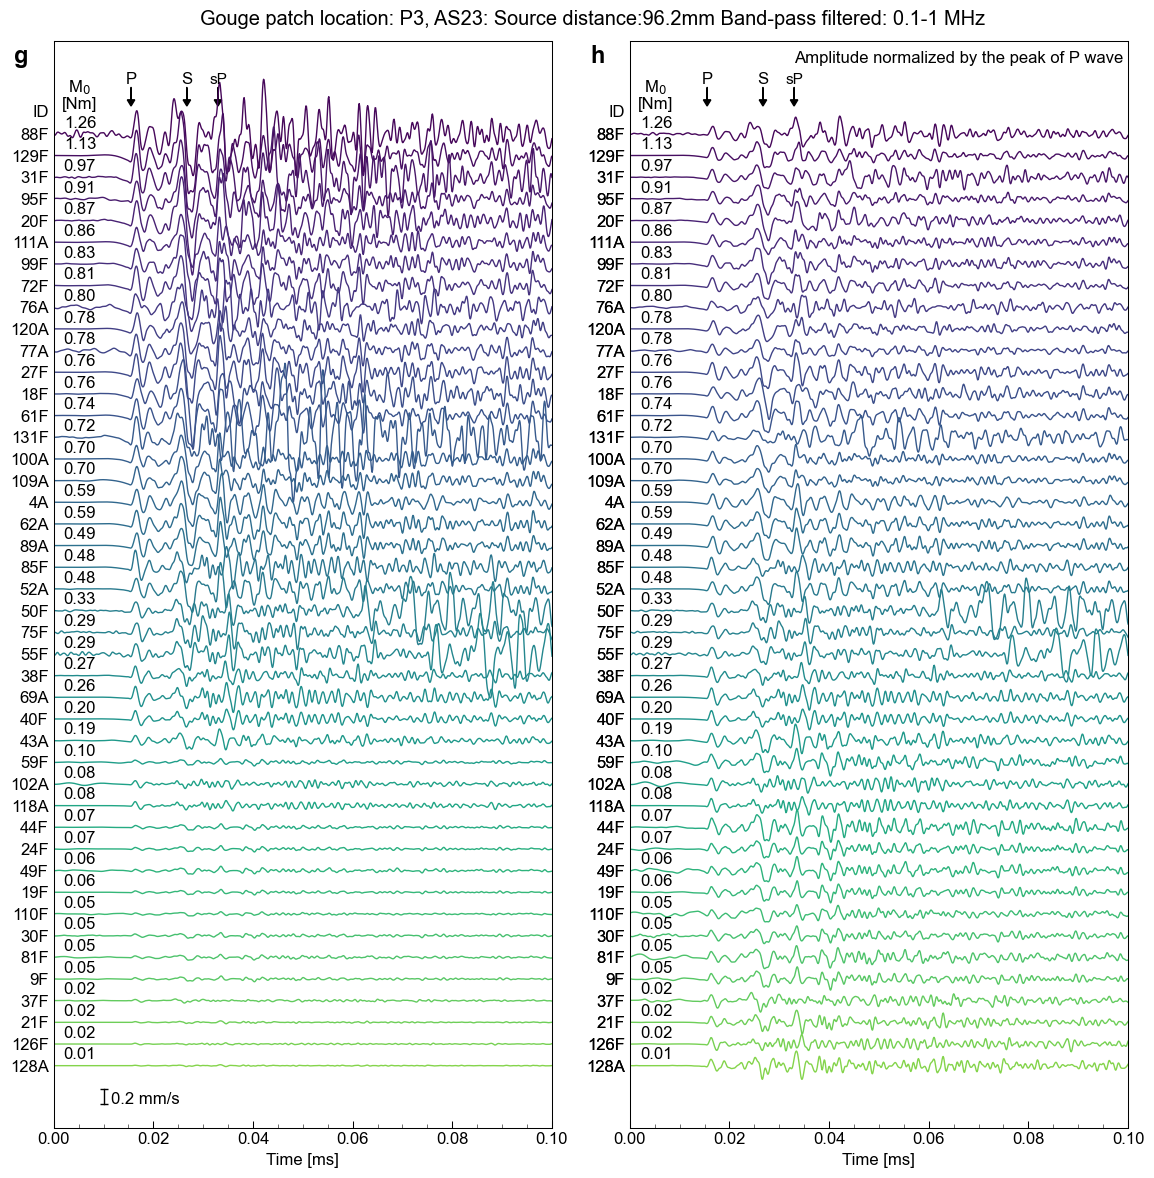

In [183]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

selected_sensor = st_filt_repick[0].stats.station
tvec = st_filt_repick[0].times()*1e3

# compute P and S arrival
tp = dist/param['cp']
ts = dist/param['cs']

yshift = 0
del_yshift = 7e-3 
ampnorm = 0.04 #0.06 
ampnorm_normalized = 5e2 # ampnorm normalized with the peak P wave amplitude

# parameters to evaluate signal to noise ratio
noise_winlen = int(5e-6*st_filt_repick[0].stats.sampling_rate) # noise window
SNR_thresh = 2.0 # threshold to correct the noramlizing factor
M0_lowSNR_thresh = 0.3
min_normalize_thresh = 3e-5 # we threshold the normalizing factor for tiny events with low S/N.

yspan = 0# 1.2e-3
expr_id = datacases[0].split('__')[0]

pretrigger = st_filt_repick[0].stats.pretrigger # [ms]
ytickloc = []
yticklabel = []

IfParrivalshift = True #False #True 

Nvalidsensors_thresh = 0 # use the source param if the number of STF fitting sensors is more than thresh

# plot absolute amplitude and normalized waveform
for j, ax in enumerate(axs):
    yshift = 0

    # Plot repeated events
    for i, datacase in enumerate(datacases_sorted):
        # i = 4
        gougeevent_id = int(datacase.split("__")[1])
        tr_ind = [x.stats.dataindex[6:] for x in st_repeat].index(datacase)
        tr_obs_filtered = st_filt_repick[tr_ind]
        assert(tr_obs_filtered.stats.dataindex[6:]==datacase) # check if the correct datacase is selected
    
        # debug: foreshock or aftershock
        event_timing=df_sourceparam_sorted[df_sourceparam_sorted.index==datacase]["eventtiming"].values[0]
        if event_timing==0:
            evtype = "F"
        else:
            evtype = "A"
        
        ytickloc.append(-yshift)
        yticklabel.append(f"{gougeevent_id:d}{evtype}")
    
        # load the onset of P wave
        onset_p_t = tvec[new_onset_p[f"{datacase}"]]
            
        # time shift to align at P wave arrival
        if IfParrivalshift:
            dtshift = (tp+pretrigger)-onset_p_t
        else:
            dtshift = 0 

        # set amplitude normalization value
        if j==0:
            plotamp = ampnorm
            lc_plot=lc_all[datacase]
        else:
            # normalize the value by P wave amplitude
            ampnorm_peak_P = peak_P_amp[datacase]
            # print(ampnorm_peak_P)
            # set minimum normalizing factor for low S/N with smaller events
            # SNR_event = np.abs(ampnorm_peak_P)/np.std(tr_obs_filtered.data[:noise_winlen])
            onset_p_ind = new_onset_p[f"{datacase}"]
            SNR_event = np.abs(ampnorm_peak_P)/np.std(tr_obs_filtered.data[onset_p_ind-noise_winlen:onset_p_ind])
            
            # print(SNR_event)
            # if np.abs(ampnorm_peak_P)<min_normalize_thresh:
            if (df_sourceparam_sorted.loc[datacase]["M0"] < M0_lowSNR_thresh) & (SNR_event < SNR_thresh):
                print(gougeevent_id)
                # floor the ampnorm
                # print("test")
                ampnorm_peak_P = min_normalize_thresh
                lc_plot="gray"
            else:
                lc_plot=lc_all[datacase]
            
            plotamp = np.abs(ampnorm_peak_P)*ampnorm_normalized
        
        ax.plot(tvec-pretrigger+dtshift, (tr_obs_filtered.data/plotamp) - yshift, "-", lw=1, c=lc_plot)
        
        yshift = yshift + del_yshift
    
    # # Annotate estimated source parameters
    annot_x = 0.0027
    annot_x_text = 0.002
    annot_y = 0.002 #-0.003
    
    for i, datacase in enumerate(datacases_sorted):
        # print(datacase)
        # M0_best = df_bestparam.loc[datacase]["M0_best"]
        # TR_best = df_bestparam.loc[datacase]["TR_best"]
        if df_sourceparam_sorted.loc[datacase, "Nvalidsensors"] >= Nvalidsensors_thresh:
            M0_best = df_sourceparam_sorted.loc[datacase, "M0"]
            Tw_best = df_sourceparam_sorted.loc[datacase, "Tw"]
        else:
            print("use waveform fit source param")
            M0_best = df_sourceparam_sorted.loc[datacase, "M0_fromwavfit"]
            Tw_best = df_sourceparam_sorted.loc[datacase, "Tw_fromwavfit"]


        # ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f},  {:.1f}".format(M0_best, TR_best), ha="left")
        ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f}".format(M0_best), ha="left")
    
    # annotate only seismic moment
    annot_txt = [r"M$_{\mathrm{0}}$"]
    annot_txt_unit = ["[Nm]"]
    ax.text(annot_x+0.0025, ytickloc[0]+0.0135, "{}".format(*annot_txt), ha="center")
    ax.text(annot_x-0.001, ytickloc[0]+0.008, "{}".format(*annot_txt_unit), ha="left")
    
    # annotate the scale of velocity
    if j==0:
        scale_x = 0.01
        scale_y = -(ytickloc[-1]-0.01)
        scale_amplitude = 0.2e-3 #[mm/s]
        ax.plot([scale_x, scale_x], np.array([-scale_amplitude/2, +scale_amplitude/2])/ampnorm-scale_y, "k-", marker="_");
        ax.text(scale_x+1.5e-3, -scale_amplitude/2/ampnorm-scale_y, f"{scale_amplitude*1e3:.1f} mm/s" )
        
    # annotate p and s arrival
    arrow_y = ytickloc[0]+0.015
    ax.arrow(tp, arrow_y, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.5e-3, color='k')
    ax.arrow(ts, arrow_y, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.5e-3, color='k')
    ax.text(tp, arrow_y+1e-3, "P", ha="center")
    ax.text(ts, arrow_y+1e-3, "S", ha="center")

    # annotate p and sp reflections from side
    # ax.arrow(pp_side_mean*1e3, arrow_y+1e-3, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.0e-3, color='k')
    ax.arrow(sP_side_mean*1e3, arrow_y, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.5e-3, color='k')
    # ax.text(pp_side_mean*1e3, arrow_y+3e-3, "pP", ha="center", fontsize=11)
    ax.text(sP_side_mean*1e3, arrow_y+1e-3, "sP", ha="center", fontsize=11)
    if repeated_sensor == "OL22":
        # plot pS
        ax.arrow(pS_side_mean*1e3, arrow_y, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.5e-3, color='k')
        ax.text(pS_side_mean*1e3, arrow_y+1e-3, "pS", ha="center", fontsize=11)
    
    # decoration of figure
    ax.text(-0.042, 0.93, "ID", transform=ax.transAxes)
    
    ax.set_xlim([0.0, 0.1])
    ax.set_ylim([ytickloc[-1]-0.02, ytickloc[0]+0.03])
    
    ax.set_xlabel("Time [ms]")
    
    ax.set_yticks(np.round(ytickloc, 3))
    ax.set_yticklabels(yticklabel)
    ax.tick_params(axis='y',length=0)

    # title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Bandpass filtered: {freqmin/1e6:g}-{freqmax/1e6:g}MHz"
    # ax.set_title(title_str)

# add suptitle
title_str = f"Gouge patch location: P3, AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Band-pass filtered: {freqmin/1e6:g}-{freqmax/1e6:g} MHz"
plt.suptitle(title_str)

# annotation
# Define labels based on the repeated_sensors
if repeated_sensor == "OL07":
    labels = ["a", "b"]
elif repeated_sensor == "OL08":
    labels = ["c", "d"]
elif repeated_sensor == "OL22":
    labels = ["e", "f"]
elif repeated_sensor == "OL23":
    labels = ["g", "h"]
else:
    labels = ["?", "?"]  # Default case if no match


axs[0].text(-0.08, 0.98, labels[0], fontweight='bold', fontsize=17, transform=axs[0].transAxes)
# axs[0].text(0.6, 0.98, "Velocity", fontsize=12, transform=axs[0].transAxes)
axs[1].text(-0.08, 0.98, labels[1], fontweight='bold', fontsize=17, transform=axs[1].transAxes)
axs[1].text(0.33, 0.98, "Amplitude normalized by the peak of P wave", fontsize=12, transform=axs[1].transAxes)


fig.tight_layout()

plt.savefig(figdir + f"/gougeevent_all_{gougepatch_id}_{repeated_sensor}_afterinstrumentalcorrection_all_sorted_timeshift{IfParrivalshift}.png", dpi=80)
plt.savefig(figdir + f"/gougeevent_all_{gougepatch_id}_{repeated_sensor}_afterinstrumentalcorrection_all_sorted_timeshift{IfParrivalshift}.eps")
# plt.savefig(figdir + "/waveform_repeated_event_{}_{}_afterinstrumentalcorrection_all_sorted.eps".format(gougepatch_id, repeated_sensor))


In [184]:
# peak_P_amp

# Plot master figure on the Figure 1

We select the events with number of STF fit sensors for the sake of visuallization. Note that we evaluate the source properties for all the events, not using the cc threshold.

In [185]:
Nvalidsensors_masterplot = 4
df_sourceparam_selected = df_sourceparam_sorted[df_sourceparam_sorted["Nvalidsensors"]==Nvalidsensors_masterplot]

In [186]:
# In the first run, we manually set the 44 events
if df_sourceparam_selected.empty: # when the first run
    print("We insert the select events for first run.")
    GPevent_selectedlist = [4,   9,  18,  19,  20,  21,  24,  27,  31,  38,  40,  43,  44,
            50,  52,  61,  62,  69,  72,  77,  85,  88,  89,  95,  99, 100,
           109, 118, 120, 126, 128, 129, 131]
    df_sourceparam_selected = df_sourceparam_sorted.loc[df_sourceparam_sorted["gougeevent_id"].isin(GPevent_selectedlist), :]

In [187]:
datacases_selected = df_sourceparam_selected.index

In [188]:
# number of gouge events
print(f"all: {len(df_sourceparam_sorted)}, Nvalid=4: {len(datacases_selected)}") # Nvalidsensors=4

all: 44, Nvalid=4: 33


In [189]:
# Color for the selected the events
skipcolor = 10
c_norm = mpl.colors.Normalize(vmin=0, vmax=len(datacases_selected)+skipcolor)
lc_selected = dict()
cmap = sns.color_palette("viridis_r", as_cmap=True)

for i, datacase in enumerate(datacases_selected[::-1]):
    lc_selected[datacase] = cmap(c_norm(i+skipcolor))


In [190]:
# Dump line color dictionary
with open(dataoutdir+f'/lc_dict_{gougepatch_id}_{repeated_sensor}.pkl', 'wb') as fo:
    pickle.dump(lc_selected, fo)
    

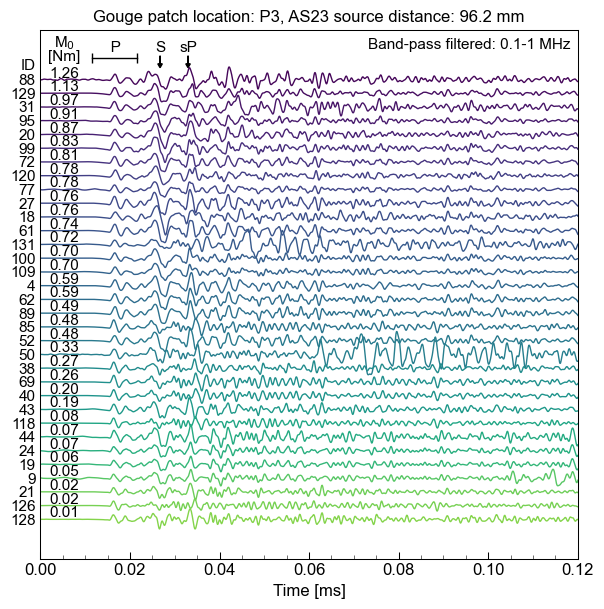

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(6.2, 6.25)) #7))

selected_sensor = st_filt_repick[0].stats.station
tvec = st_filt_repick[0].times()*1e3

# compute P and S arrival
tp = dist/param['cp']
ts = dist/param['cs']

yshift = 0
del_yshift = 7e-3 
ampnorm = 0.04 #0.06 
ampnorm_normalized = 4.5e2 #6e2 # ampnorm normalized with the peak P wave amplitude

# parameters to evaluate signal to noise ratio
noise_winlen = int(5e-6*st_filt_repick[0].stats.sampling_rate) # noise window
SNR_thresh = 2.0 # threshold to correct the noramlizing factor
M0_lowSNR_thresh = 0.3
min_normalize_thresh = 3e-5 # we threshold the normalizing factor for tiny events with low S/N.

yspan = 0# 1.2e-3
expr_id = datacases[0].split('__')[0]

pretrigger = st_filt_repick[0].stats.pretrigger # [ms]
ytickloc = []
yticklabel = []

IfParrivalshift = True #False #True 

yshift = 0
normalize_j= 1

ifPolarityPos = False

# Plot repeated events
for i, datacase in enumerate(datacases_selected):
    # i = 4
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.dataindex[6:] for x in st_repeat].index(datacase)
    tr_obs_filtered = st_filt_repick[tr_ind]
    # tr_obs_filtered_plot = st_filt_plot[tr_ind]
    assert(tr_obs_filtered.stats.dataindex[6:]==datacase) # check if the correct datacase is selected

    # debug: foreshock or aftershock
    event_timing=df_sourceparam_selected[df_sourceparam_selected.index==datacase]["eventtiming"].values[0]
    if event_timing==0:
        evtype = "F"
    else:
        evtype = "A"
    
    ytickloc.append(-yshift)
    # yticklabel.append(f"{gougeevent_id:d}{evtype}")
    yticklabel.append(f"{gougeevent_id:d}")

    # load the onset of P wave
    onset_p_t = tvec[new_onset_p[f"{datacase}"]]
        
    # time shift to align at P wave arrival
    if IfParrivalshift:
        dtshift = (tp+pretrigger)-onset_p_t
    else:
        dtshift = 0 

    # set amplitude normalization value
    if normalize_j==0:
        plotamp = ampnorm
        lc_plot=lc_all[datacase]
    else:
        # normalize the value by P wave amplitude
        ampnorm_peak_P = peak_P_amp[datacase]
        # print(ampnorm_peak_P)
        # set minimum normalizing factor for low S/N with smaller events
        # SNR_event = np.abs(ampnorm_peak_P)/np.std(tr_obs_filtered.data[:noise_winlen])
        onset_p_ind = new_onset_p[f"{datacase}"]
        SNR_event = np.abs(ampnorm_peak_P)/np.std(tr_obs_filtered.data[onset_p_ind-noise_winlen:onset_p_ind])
            
        # print(SNR_event)
        # if np.abs(ampnorm_peak_P)<min_normalize_thresh:
        # if (df_bestparam.loc[datacase]["M0_best"] < M0_lowSNR_thresh) & (SNR_event < SNR_thresh):
        if (df_sourceparam_selected.loc[datacase, "M0"] < M0_lowSNR_thresh) & (SNR_event < SNR_thresh):
            # floor the ampnorm
            # print("test")
            ampnorm_peak_P = min_normalize_thresh
            lc_plot="gray"
            # We skip plotting the low S/N for Figure 1
            print(f"skip {datacase} due to low SNR.")
            continue
        else:
            lc_plot=lc_all[datacase]

        plotamp = np.abs(ampnorm_peak_P)*ampnorm_normalized
    
    # print(gougeevent_id, plotamp)

    if ifPolarityPos:
        polarity = -1 * np.sign(tr_obs_filtered.stats.xi1) * np.sign(channel_loc[repeated_sensor][1])
    else:
        polarity = 1
        
    ax.plot(tvec-pretrigger+dtshift, (tr_obs_filtered.data/plotamp) - yshift, "-", lw=1, c=lc_plot)
    # ax.plot(tvec-pretrigger+dtshift, (tr_obs_filtered_plot.data/plotamp) - yshift, "-", lw=1, c=lc_plot)
    
    yshift = yshift + del_yshift

    # # Annotate estimated source parameters
    annot_x = 0.0027
    annot_x_text = 0.002
    annot_y = 0.001 #-0.003
    
    # for i, datacase in enumerate(datacases_selected):
    # print(datacase)
    # M0_best = df_bestparam.loc[datacase]["M0_best"]
    # TR_best = df_bestparam.loc[datacase]["TR_best"]
    if df_sourceparam_sorted.loc[datacase, "Nvalidsensors"] >= Nvalidsensors_thresh:
        M0_best = df_sourceparam_selected.loc[datacase, "M0"]
        Tw_best = df_sourceparam_selected.loc[datacase, "Tw"]
    else:
        print("use waveform fit source param")
        M0_best = df_sourceparam_selected.loc[datacase, "M0_fromwavfit"]
        Tw_best = df_sourceparam_selected.loc[datacase, "Tw_fromwavfit"]

    assert(len(df_sourceparam_selected.loc[datacase, :] == 1))
    # M0_best_fromSTFfit = df_stacked_sorted[df_stacked_sorted["datacase"] == datacase]["M0_mean"].values[0]
    # Tw_best_fromSTFfit = df_stacked_sorted[df_stacked_sorted["datacase"] == datacase]["Tw_mean"].values[0] * 1e6
    # ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f},  {:.1f}".format(M0_best, TR_best), ha="left")
    # ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f}".format(M0_best), ha="left")
    ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f}".format(M0_best), ha="left", fontsize=11)
    # ax.text(annot_x_text+0.01, ytickloc[i]+annot_y, r"{:.2f}".format(M0_best), ha="left", c="b") # debug from best fit param

# annotate only seismic moment
annot_txt = [r"M$_{\mathrm{0}}$"]
annot_txt_unit = ["[Nm]"]
ax.text(annot_x+0.0028, ytickloc[0]+0.0165, "{}".format(*annot_txt), ha="center", fontsize=11)
ax.text(annot_x-0.001, ytickloc[0]+0.0094, "{}".format(*annot_txt_unit), ha="left", fontsize=11)

# annotate the scale of velocity
if normalize_j==0:
    scale_x = 0.01
    scale_y = -(ytickloc[-1]-0.01)
    scale_amplitude = 0.2e-3 #[mm/s]
    ax.plot([scale_x, scale_x], np.array([-scale_amplitude/2, +scale_amplitude/2])/ampnorm-scale_y, "k-");
    ax.text(scale_x+0.001, -scale_amplitude/2/ampnorm-scale_y, f"{scale_amplitude*1e3:.1f} mm/s" )
    
# annotate p and s arrival
arrow_y = 1.1e-2 #ytickloc[0]+0.015
# s_arrival_shift = 2e-3
# ax.arrow(tp, arrow_y, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.5e-3, color='k')
ax.arrow(ts, arrow_y+1e-3, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.0e-3, color='k')
# ax.text(tp, arrow_y-0.6e-3, " P", ha="left")
ax.text(ts, arrow_y+3e-3, "S", ha="center", fontsize=11)

# annotate p and sp reflections from side
# ax.arrow(pp_side_mean*1e3, arrow_y+1e-3, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.0e-3, color='k')
# ax.arrow(pS_side_mean*1e3, arrow_y+1e-3, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.0e-3, color='k')
ax.arrow(sP_side_mean*1e3, arrow_y+1e-3, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.0e-3, color='k')
# ax.text(pp_side_mean*1e3, arrow_y+3e-3, "pP", ha="center", fontsize=11)
# ax.text(pS_side_mean*1e3, arrow_y+3e-3, "    pS", ha="center", fontsize=11)
ax.text(sP_side_mean*1e3, arrow_y+3e-3, "sP", ha="center", fontsize=11)

# annotate p pulse window used to compute far-field displacement pulse
arrow_y = 1.1e-2 # 6e-3
pwin_pre = 4e-6 # taken from the values in the following cell
pwin_len = 6e-6
pp = tp #np.mean(pp_all) # aligned timing at average distance divided by the velocity

ax.plot([pp-pwin_pre*1e3, pp+pwin_len*1e3], [arrow_y, arrow_y], "k-", marker="|", ms=7, markeredgewidth=1)
ax.text(pp, arrow_y+3e-3, "   P", ha="center", fontsize=11)

# decoration of figure
# ax.text(-0.036, 0.922, "ID", transform=ax.transAxes)
ax.text(-0.036, 0.925, "ID", transform=ax.transAxes, fontsize=11)

ax.set_xlim([0.0, 0.12])
# ax.set_ylim([ytickloc[-1]-0.01, ytickloc[0]+0.025]) # use this to remove the bottom space
ax.set_ylim([ytickloc[-1]-0.02, ytickloc[0]+0.025])

ax.set_xlabel("Time [ms]")

ax.set_yticks(np.round(ytickloc, 3))
ax.set_yticklabels(yticklabel, fontsize=11)
ax.tick_params(axis='y',length=0)

# title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Bandpass filtered: {freqmin/1e6:g}-{freqmax/1e6:g}MHz"
# ax.set_title(title_str)

# add suptitle
# title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Bandpass filtered: {freqmin/1e6:g}-{freqmax/1e6:g}MHz"
gouge_x = 1.75 # gouge patch at G3 
# title_str = f"Asperity patch location: G3, AS{selected_sensor[2:]} source distance: {dist:.1f} mm"
title_str = f"Gouge patch location: P3, AS{selected_sensor[2:]} source distance: {dist:.1f} mm"
ax.set_title(title_str, fontsize=12)

ax.text(0.61, 0.965, f"Band-pass filtered: {freqmin/1e6:g}-{freqmax/1e6:.1g} MHz", transform=ax.transAxes, fontsize=11)

fig.tight_layout()

plt.savefig(figdir + f"/Fig1_gougeevent_selected_{gougepatch_id}_{repeated_sensor}_normalize_{normalize_j}_all_sorted_timeshift{IfParrivalshift}_Polaritypos{ifPolarityPos}.png", dpi=80)
plt.savefig(figdir + f"/Fig1_gougeevent_selected_{gougepatch_id}_{repeated_sensor}_normalize_{normalize_j}_all_sorted_timeshift{IfParrivalshift}_Polaritypos{ifPolarityPos}.eps")


## Plot superimposed normalized waveforms

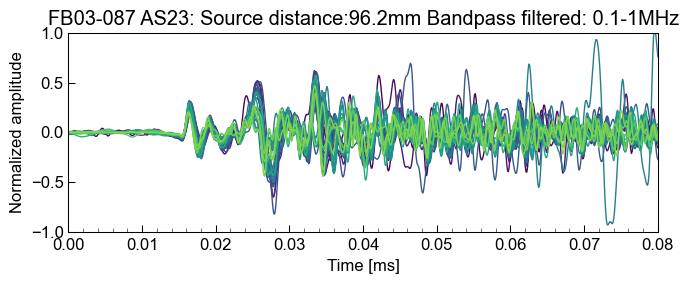

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3)) #7))

selected_sensor = st_filt_repick[0].stats.station
tvec = st_filt_repick[0].times()*1e3

yspan = 0# 1.2e-3
expr_id = datacases[0].split('__')[0]

ytickloc = []
yticklabel = []

IfParrivalshift = True #False #True 

yshift = 0
normalize_j= 1

ampnorm_normalized = 5

# Plot repeated events
for i, datacase in enumerate(datacases_selected):
    # i = 4
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.dataindex[6:] for x in st_repeat].index(datacase)
    tr_obs_filtered = st_filt_repick[tr_ind]
    assert(tr_obs_filtered.stats.dataindex[6:]==datacase) # check if the correct datacase is selected

    # debug: foreshock or aftershock
    event_timing=df_sourceparam_selected[df_sourceparam_selected.index==datacase]["eventtiming"].values[0]
    if event_timing==0:
        evtype = "F"
    else:
        evtype = "A"
    
    ytickloc.append(-yshift)
    # yticklabel.append(f"{gougeevent_id:d}{evtype}")
    yticklabel.append(f"{gougeevent_id:d}")

    # load the onset of P wave
    onset_p_t = tvec[new_onset_p[f"{datacase}"]]
        
    # time shift to align at P wave arrival
    if IfParrivalshift:
        dtshift = (tp+pretrigger)-onset_p_t
    else:
        dtshift = 0 

    # set amplitude normalization value
    if normalize_j==0:
        plotamp = ampnorm
        lc_plot=lc_all[datacase]
    else:
        # normalize the value by P wave amplitude
        ampnorm_peak_P = peak_P_amp[datacase]
        # print(ampnorm_peak_P)
        # set minimum normalizing factor for low S/N with smaller events
        SNR_event = np.abs(ampnorm_peak_P)/np.std(tr_obs_filtered.data[:noise_winlen])
        # print(SNR_event)
        # if np.abs(ampnorm_peak_P)<min_normalize_thresh:
        if (df_sourceparam_selected.loc[datacase, "M0"] < M0_lowSNR_thresh) & (SNR_event < SNR_thresh):
            # floor the ampnorm
            # print("test")
            ampnorm_peak_P = min_normalize_thresh
            lc_plot="gray"
            # We skip plotting the low S/N for Figure 1
            print(f"skip {datacase} due to low SNR.")
            continue
        else:
            lc_plot=lc_all[datacase]
        
        plotamp = np.abs(ampnorm_peak_P)*ampnorm_normalized
    
    ax.plot(tvec-pretrigger+dtshift, (tr_obs_filtered.data/plotamp) - yshift, "-", lw=1, c=lc_plot)
    
    # yshift = yshift + del_yshift

# # decoration of figure
# ax.text(-0.036, 0.925, "ID", transform=ax.transAxes)

ax.set_xlim([0.0, 0.08])
ax.set_ylim([-1, 1])
# ax.set_ylim([ytickloc[-1]-0.01, ytickloc[0]+0.02])

ax.set_xlabel("Time [ms]")
ax.set_ylabel("Normalized amplitude")
# ax.set_yticks(np.round(ytickloc, 3))
# ax.set_yticklabels(yticklabel)

title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Bandpass filtered: {freqmin/1e6:g}-{freqmax/1e6:g}MHz"
ax.set_title(title_str)

# ax.text(0.605, 0.96, f"Band-pass filtered: {freqmin/1e6:g}-{freqmax/1e6:.1g} MHz", transform=ax.transAxes)
ax.tick_params(axis='x', which='major', pad=5)
fig.tight_layout()

plt.savefig(figdir + f"/Fig1aux_supimp_gougeevent_selected_{gougepatch_id}_{repeated_sensor}_normalize_{normalize_j}_all_sorted_timeshift{IfParrivalshift}.png", dpi=80)
# plt.savefig(figdir + f"/Fig1aux_supimp_gougeevent_selected_{gougepatch_id}_{repeated_sensor}_all_sorted_timeshift{IfParrivalshift}.pdf")


## Plot velocity without amplitude normalization

In [193]:
deg_Ps, deg_sP

((40.97638795968303, 22.38057312069037),
 (18.37450346301727, 32.88062713764262))

In [194]:
tr.stats.eta1, tr.stats.xi1

(-0.05625, 0.03699999999999992)

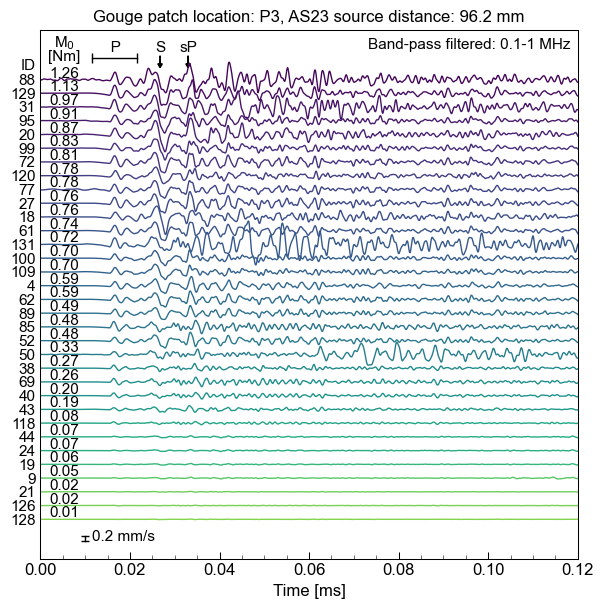

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(6.2, 6.25)) #figsize=(7, 7.3)) #7))

selected_sensor = st_filt_repick[0].stats.station
tvec = st_filt_repick[0].times()*1e3

yshift = 0
del_yshift = 7e-3 

if repeated_sensor in ["OL23", "OL07"]:
    ampnorm = 0.08 #0.04 #0.06 
else:
    ampnorm = 0.035 #0.04 #0.06 

yspan = 0# 1.2e-3
expr_id = datacases[0].split('__')[0]

pretrigger = st_filt_repick[0].stats.pretrigger # [ms]
ytickloc = []
yticklabel = []

IfParrivalshift = True #False #True 

yshift = 0
normalize_j= 0

ifPolarityPos = False # plot the polarity as positive

# Plot repeated events
for i, datacase in enumerate(datacases_selected):
    # i = 4
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.dataindex[6:] for x in st_repeat].index(datacase)
    tr_obs_filtered = st_filt_repick[tr_ind]
    assert(tr_obs_filtered.stats.dataindex[6:]==datacase) # check if the correct datacase is selected

    # debug: foreshock or aftershock
    event_timing=df_sourceparam_selected[df_sourceparam_selected.index==datacase]["eventtiming"].values[0]
    if event_timing==0:
        evtype = "F"
    else:
        evtype = "A"
    
    ytickloc.append(-yshift)
    # yticklabel.append(f"{gougeevent_id:d}{evtype}")
    yticklabel.append(f"{gougeevent_id:d}")

    # load the onset of P wave
    onset_p_t = tvec[new_onset_p[f"{datacase}"]]
        
    # time shift to align at P wave arrival
    if IfParrivalshift:
        dtshift = (tp+pretrigger)-onset_p_t
    else:
        dtshift = 0 

    # set amplitude normalization value
    if normalize_j==0:
        plotamp = ampnorm
        lc_plot=lc_all[datacase]
    else:
        # normalize the value by P wave amplitude
        ampnorm_peak_P = peak_P_amp[datacase]
        # print(ampnorm_peak_P)
        # set minimum normalizing factor for low S/N with smaller events
        SNR_event = np.abs(ampnorm_peak_P)/np.std(tr_obs_filtered.data[:noise_winlen])
        # print(SNR_event)
        # if np.abs(ampnorm_peak_P)<min_normalize_thresh:
        if (df_sourceparam_selected.loc[datacase, "M0"] < M0_lowSNR_thresh) & (SNR_event < SNR_thresh):
            # floor the ampnorm
            # print("test")
            ampnorm_peak_P = min_normalize_thresh
            lc_plot="gray"
            # We skip plotting the low S/N for Figure 1
            print(f"skip {datacase} due to low SNR.")
            continue
        else:
            lc_plot=lc_all[datacase]
        
        plotamp = np.abs(ampnorm_peak_P)*ampnorm_normalized

    if ifPolarityPos:
        polarity = -1 * np.sign(tr_obs_filtered.stats.xi1) * np.sign(channel_loc[repeated_sensor][1])
    else:
        polarity = 1
        
    ax.plot(tvec-pretrigger+dtshift, polarity * (tr_obs_filtered.data/plotamp) - yshift, "-", lw=1, c=lc_plot)
    
    yshift = yshift + del_yshift

    # # Annotate estimated source parameters
    annot_x = 0.0027
    annot_x_text = 0.002
    annot_y = 0.001 #-0.003
    
    # for i, datacase in enumerate(datacases_selected):
    # print(datacase)
    # M0_best = df_bestparam.loc[datacase]["M0_best"]
    # TR_best = df_bestparam.loc[datacase]["TR_best"]
    if df_sourceparam_sorted.loc[datacase, "Nvalidsensors"] >= Nvalidsensors_thresh:
        M0_best = df_sourceparam_selected.loc[datacase, "M0"]
        Tw_best = df_sourceparam_selected.loc[datacase, "Tw"]
    else:
        print("use waveform fit source param")
        M0_best = df_sourceparam_selected.loc[datacase, "M0_fromwavfit"]
        Tw_best = df_sourceparam_selected.loc[datacase, "Tw_fromwavfit"]

    assert(len(df_sourceparam_selected.loc[datacase, :] == 1))
    # ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f},  {:.1f}".format(M0_best, TR_best), ha="left")
    ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f}".format(M0_best), ha="left", fontsize=11)

# annotate only seismic moment
annot_txt = [r"M$_{\mathrm{0}}$"]
annot_txt_unit = ["[Nm]"]
ax.text(annot_x+0.0028, ytickloc[0]+0.0165, "{}".format(*annot_txt), ha="center", fontsize=11)
ax.text(annot_x-0.001, ytickloc[0]+0.0094, "{}".format(*annot_txt_unit), ha="left", fontsize=11)

# annotate the scale of velocity
if normalize_j==0:
    scale_x = 0.01
    scale_y = -(ytickloc[-1]-0.01)
    scale_amplitude = 0.2e-3 #[mm/s]
    ax.plot([scale_x, scale_x], np.array([-scale_amplitude/2, +scale_amplitude/2])/ampnorm-scale_y, "k-", marker="_");
    ax.text(scale_x+0.0015, -scale_amplitude/2/ampnorm-scale_y, f"{scale_amplitude*1e3:.1f} mm/s", fontsize=11)
    
# annotate p and s arrival
arrow_y = 1.1e-2 #ytickloc[0]+0.015
# s_arrival_shift = 2e-3
# ax.arrow(tp, arrow_y, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.5e-3, color='k')
ax.arrow(ts, arrow_y+1e-3, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.0e-3, color='k')
# ax.text(tp, arrow_y-0.6e-3, " P", ha="left")
ax.text(ts, arrow_y+3e-3, "S", ha="center", fontsize=11)

# annotate p and sp reflections from side
# ax.arrow(pp_side_mean*1e3, arrow_y+1e-3, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.0e-3, color='k')
# ax.arrow(pS_side_mean*1e3, arrow_y+1e-3, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.0e-3, color='k')
ax.arrow(sP_side_mean*1e3, arrow_y+1e-3, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.0e-3, color='k')
# ax.text(pp_side_mean*1e3, arrow_y+3e-3, "pP", ha="center", fontsize=11)
# ax.text(pS_side_mean*1e3, arrow_y+3e-3, "    pS", ha="center", fontsize=11)
ax.text(sP_side_mean*1e3, arrow_y+3e-3, "sP", ha="center", fontsize=11)

# annotate p pulse window used to compute far-field displacement pulse
arrow_y = 1.1e-2 # 6e-3
pwin_pre = 4e-6 # taken from the values in the following cell
pwin_len = 6e-6
pp = tp #np.mean(pp_all) # aligned timing at average distance divided by the velocity

ax.plot([pp-pwin_pre*1e3, pp+pwin_len*1e3], [arrow_y, arrow_y], "k-", marker="|", ms=7, markeredgewidth=1)
ax.text(pp, arrow_y+3e-3, "   P", ha="center", fontsize=11)


# annotate s pulse window
# arrow_y = 1.1e-2 # 6e-3
# swin_pre = 2e-6 # taken from the values in the following cell
# swin_len = 8e-6
# ps = ts

# ax.plot([ps-swin_pre*1e3, ps+swin_len*1e3], [arrow_y, arrow_y], "k-", marker="|", ms=7, markeredgewidth=1)
# ax.text(ps, arrow_y+3e-3, "       S", ha="center", fontsize=11)


# decoration of figure
ax.text(-0.036, 0.925, "ID", transform=ax.transAxes, fontsize=11)

ax.set_xlim([0.0, 0.12])
ax.set_ylim([ytickloc[-1]-0.02, ytickloc[0]+0.025])

ax.set_xlabel("Time [ms]")

ax.set_yticks(np.round(ytickloc, 3))
ax.set_yticklabels(yticklabel, fontsize=11)
ax.tick_params(axis='y',length=0)

# title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Bandpass filtered: {freqmin/1e6:g}-{freqmax/1e6:g}MHz"
# ax.set_title(title_str)

# add suptitle
# title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Bandpass filtered: {freqmin/1e6:g}-{freqmax/1e6:g}MHz"
gouge_x = 1.75 # gouge patch at G3 
title_str = f"Gouge patch location: P3, AS{selected_sensor[2:]} source distance: {dist:.1f} mm"
ax.set_title(title_str, fontsize=12)

ax.text(0.61, 0.965, f"Band-pass filtered: {freqmin/1e6:g}-{freqmax/1e6:.1g} MHz", transform=ax.transAxes, fontsize=11)

fig.tight_layout()

plt.savefig(figdir + f"/Fig1_gougeevent_selected_{gougepatch_id}_{repeated_sensor}_{normalize_j}_all_sorted_timeshift{IfParrivalshift}_Polaritypos{ifPolarityPos}.png", dpi=80)
plt.savefig(figdir + f"/Fig1_gougeevent_selected_{gougepatch_id}_{repeated_sensor}_{normalize_j}_all_sorted_timeshift{IfParrivalshift}_Polaritypos{ifPolarityPos}.eps")


# Plot P wave window

Plot P wave window for the introduction figure. We align at the peak P amplitude of the velocity waveforms.



In [196]:
peak_P_ind

{'fb03-087__0088': 272,
 'fb03-087__0129': 275,
 'fb03-087__0031': 276,
 'fb03-087__0095': 272,
 'fb03-087__0020': 272,
 'fb03-087__0111': 274,
 'fb03-087__0099': 275,
 'fb03-087__0072': 275,
 'fb03-087__0076': 267,
 'fb03-087__0120': 275,
 'fb03-087__0077': 270,
 'fb03-087__0027': 274,
 'fb03-087__0018': 272,
 'fb03-087__0061': 275,
 'fb03-087__0131': 268,
 'fb03-087__0100': 273,
 'fb03-087__0109': 274,
 'fb03-087__0004': 273,
 'fb03-087__0062': 274,
 'fb03-087__0089': 273,
 'fb03-087__0085': 272,
 'fb03-087__0052': 274,
 'fb03-087__0050': 267,
 'fb03-087__0075': 263,
 'fb03-087__0055': 265,
 'fb03-087__0038': 272,
 'fb03-087__0069': 271,
 'fb03-087__0040': 268,
 'fb03-087__0043': 270,
 'fb03-087__0059': 269,
 'fb03-087__0102': 264,
 'fb03-087__0118': 267,
 'fb03-087__0044': 273,
 'fb03-087__0024': 269,
 'fb03-087__0049': 269,
 'fb03-087__0019': 267,
 'fb03-087__0110': 253,
 'fb03-087__0030': 263,
 'fb03-087__0081': 268,
 'fb03-087__0009': 267,
 'fb03-087__0037': 252,
 'fb03-087__0021

In [197]:
pt_align_event = 129 # align the P wave at this event
pt_align = tvec[peak_P_ind[f'fb03-087__{pt_align_event:04d}']]-pretrigger
pt_align

0.0175

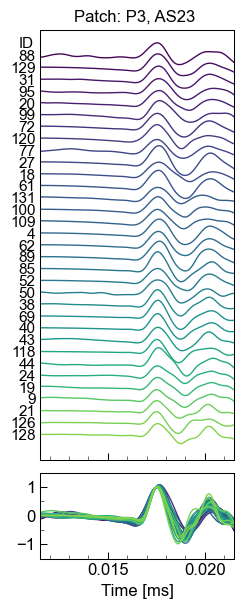

In [198]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(2.6, 6.25), gridspec_kw={'height_ratios': [5, 1]}, sharex=True) #7))

selected_sensor = st_filt_repick[0].stats.station
tvec = st_filt_repick[0].times()*1e3

yshift = 0
del_yshift = 7e-3 

if repeated_sensor in ["OL23", "OL07"]:
    ampnorm = 0.08 #0.04 #0.06 
else:
    ampnorm = 0.03#0.04 #0.06 

yspan = 0# 1.2e-3
expr_id = datacases[0].split('__')[0]

pretrigger = st_filt_repick[0].stats.pretrigger # [ms]
ytickloc = []
yticklabel = []

# IfParrivalshift = True #False #True 
IfPpeakshift = True # align at the P peak

yshift = 0
normalize_j= 1
ampnorm_normalized = 1.6e2

ifPolarityPos = False # plot the polarity as positive


# Plot repeated events
for i, datacase in enumerate(datacases_selected):
    # i = 4
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.dataindex[6:] for x in st_repeat].index(datacase)
    tr_obs_filtered = st_filt_repick[tr_ind]
    assert(tr_obs_filtered.stats.dataindex[6:]==datacase) # check if the correct datacase is selected

    # debug: foreshock or aftershock
    event_timing=df_sourceparam_selected[df_sourceparam_selected.index==datacase]["eventtiming"].values[0]
    if event_timing==0:
        evtype = "F"
    else:
        evtype = "A"
    
    ytickloc.append(-yshift)
    # yticklabel.append(f"{gougeevent_id:d}{evtype}")
    yticklabel.append(f"{gougeevent_id:d}")

    # load the onset of P wave
    onset_p_t = tvec[new_onset_p[f"{datacase}"]]
        
    # time shift to align at P wave arrival
    # if IfParrivalshift:
    #     dtshift = (tp+pretrigger)-onset_p_t
    # else:
    #     dtshift = 0 
    if IfPpeakshift:
        Ppeak_event = tvec[peak_P_ind[datacase]]-pretrigger
        dtshift = pt_align - Ppeak_event
    else:
        dtshift = 0

    # set amplitude normalization value
    if normalize_j==0:
        plotamp = ampnorm
        lc_plot=lc_all[datacase]
    else:
        # normalize the value by P wave amplitude
        ampnorm_peak_P = peak_P_amp[datacase]
        # print(ampnorm_peak_P)
        # set minimum normalizing factor for low S/N with smaller events
        SNR_event = np.abs(ampnorm_peak_P)/np.std(tr_obs_filtered.data[:noise_winlen])
        # print(SNR_event)
        # if np.abs(ampnorm_peak_P)<min_normalize_thresh:
        if (df_sourceparam_selected.loc[datacase, "M0"] < M0_lowSNR_thresh) & (SNR_event < SNR_thresh):
            # floor the ampnorm
            # print("test")
            ampnorm_peak_P = min_normalize_thresh
            lc_plot="gray"
            # We skip plotting the low S/N for Figure 1
            print(f"skip {datacase} due to low SNR.")
            continue
        else:
            lc_plot=lc_all[datacase]
        
        plotamp = np.abs(ampnorm_peak_P)*ampnorm_normalized

    if ifPolarityPos:
        polarity = -1 * np.sign(tr_obs_filtered.stats.xi1) * np.sign(channel_loc[repeated_sensor][1])
    else:
        polarity = 1
        
    ax.plot(tvec-pretrigger+dtshift, polarity * (tr_obs_filtered.data/plotamp) - yshift, "-", lw=1, c=lc_plot)
    
    yshift = yshift + del_yshift

    # # Annotate estimated source parameters
    annot_x = 0.0027
    annot_x_text = 0.002
    annot_y = 0.001 #-0.003
    
    # for i, datacase in enumerate(datacases_selected):
    # print(datacase)
    # M0_best = df_bestparam.loc[datacase]["M0_best"]
    # TR_best = df_bestparam.loc[datacase]["TR_best"]
    if df_sourceparam_sorted.loc[datacase, "Nvalidsensors"] >= Nvalidsensors_thresh:
        M0_best = df_sourceparam_selected.loc[datacase, "M0"]
        Tw_best = df_sourceparam_selected.loc[datacase, "Tw"]
    else:
        print("use waveform fit source param")
        M0_best = df_sourceparam_selected.loc[datacase, "M0_fromwavfit"]
        Tw_best = df_sourceparam_selected.loc[datacase, "Tw_fromwavfit"]

    assert(len(df_sourceparam_selected.loc[datacase, :] == 1))
    # ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f},  {:.1f}".format(M0_best, TR_best), ha="left")
    # ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f}".format(M0_best), ha="left")

    #---Plot superimposed waveform---#
    # normalize the peak as unity
    Pamp_abs = np.abs(tr_obs_filtered.data[peak_P_ind[datacase]])
    # ax2.plot(tvec-pretrigger+dtshift, polarity * (tr_obs_filtered.data/plotamp*ampnorm_normalized), "-", lw=1, c=lc_plot)
    ax2.plot(tvec-pretrigger+dtshift, polarity * (tr_obs_filtered.data/Pamp_abs), "-", lw=1, c=lc_plot)

# annotate only seismic moment
annot_txt = [r"M$_{\mathrm{0}}$"]
annot_txt_unit = ["[Nm]"]
# ax.text(annot_x+0.0025, ytickloc[0]+0.0145, "{}".format(*annot_txt), ha="center")
# ax.text(annot_x-0.001, ytickloc[0]+0.009, "{}".format(*annot_txt_unit), ha="left")

# annotate the scale of velocity
if normalize_j==0:
    scale_x = 0.028 #0.01
    scale_y = -(ytickloc[-1]-0.01)
    scale_amplitude = 0.2e-3 #[mm/s]
    ax.plot([scale_x, scale_x], np.array([-scale_amplitude/2, +scale_amplitude/2])/ampnorm-scale_y, "k-");
    ax.text(scale_x+0.001, -scale_amplitude/2/ampnorm-scale_y, f"{scale_amplitude*1e3:.1f} mm/s" )
    
# annotate p and s arrival
# arrow_y = ytickloc[0]+0.015
# ax.arrow(tp, arrow_y, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.5e-3, color='k')
# ax.arrow(ts, arrow_y, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3,head_width=1.5e-3, color='k')
# ax.text(tp, arrow_y-0.6e-3, " P", ha="left")
# ax.text(ts, arrow_y-0.6e-3, " S", ha="left")

# annotate p pulse window used to compute far-field displacement pulse
arrow_y = 1.5e-2 # 6e-3
pwin_pre = 4e-6 # taken from the values in the following cell
pwin_len = 6e-6
pp = tp #np.mean(pp_all) # aligned timing at average distance divided by the velocity

# ax.plot([pp-pwin_pre*1e3, pp+pwin_len*1e3], [arrow_y, arrow_y], "r-", marker="|", ms=7, markeredgewidth=1)
# ax.text(pp, arrow_y+3e-3, "   P", ha="center")

# decoration of figure
ax.text(-0.11, 0.96, "ID", transform=ax.transAxes, fontsize=11)

# ax.set_xlim([0.0, 0.12])
ax.set_xlim([pp-pwin_pre*1e3, pp+pwin_len*1e3])
# ax.set_ylim([ytickloc[-1]-0.02, ytickloc[0]+0.025])
ax.set_ylim([ytickloc[-1]-0.015, ytickloc[0]+0.015])

# ax.set_xlabel("Time [ms]")

ax.set_yticks(np.round(ytickloc, 3))
ax.set_yticklabels(yticklabel, fontsize=11)
ax.tick_params(axis='y',length=0)

# title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Bandpass filtered: {freqmin/1e6:g}-{freqmax/1e6:g}MHz"
# ax.set_title(title_str)

# add suptitle
# title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Bandpass filtered: {freqmin/1e6:g}-{freqmax/1e6:g}MHz"
gouge_x = 1.75 # gouge patch at G3 
# title_str = f"Asperity patch location: G3, AS{selected_sensor[2:]} source distance: {dist:.1f} mm"
title_str = f"Patch: P3, AS{selected_sensor[2:]} "
ax.set_title(title_str, fontsize=12)

# ax.text(0.605, 0.96, f"Band-pass filtered: {freqmin/1e6:g}-{freqmax/1e6:.1g} MHz", transform=ax.transAxes)

ax2.set_ylim([-1.5, 1.5])
ax2.set_xlabel("Time [ms]")
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))


fig.tight_layout()

plt.subplots_adjust(hspace=0.05)


plt.savefig(figdir + f"/Fig1Pwin_gougeevent_selected_{gougepatch_id}_{repeated_sensor}_{normalize_j}_all_sorted_timeshift{IfParrivalshift}_Polaritypos{ifPolarityPos}.png", dpi=80)
plt.savefig(figdir + f"/Fig1Pwin_gougeevent_selected_{gougepatch_id}_{repeated_sensor}_{normalize_j}_all_sorted_timeshift{IfParrivalshift}_Polaritypos{ifPolarityPos}.eps")


**NOTE:** The normalization P amplitude is measured by the relative value between the onset and the peak P in the early part of this notebook. Here we recompute the noramlizing factor by the absolute P peak amplitude.

In [199]:
polarity

1

In [200]:
tr_obs_filtered.data[peak_P_ind[datacase]]

5.323060139195592e-06

# Conclusion

This notebook computes the onset of the P wave pulse and plots the gouge events for the master figures. The onset time is dumped to the csv file, which is used to trim the P wave window in the next notebook.